# Demo object and attribute predictions


### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [ ]:
# Change dir to caffe root or prototxt database paths won't work wrong
import os
os.chdir('..')

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
sys.path.insert(0, './caffe/python/')
sys.path.insert(0, './lib/')
sys.path.insert(0, './tools/')
import caffe

In [3]:
caffe.set_mode_gpu()
caffe.set_device(1)

In [4]:
data_path = './data/genome/1600-400-20'

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [5]:
# Check object extraction
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect,_get_blobs
from fast_rcnn.nms_wrapper import nms
import cv2

GPU_ID = 3   # if we have multiple GPUs, pick one 
caffe.set_device(GPU_ID)  
caffe.set_mode_gpu()
net = None
cfg_from_file('experiments/cfgs/faster_rcnn_end2end_resnet.yml')

weights = './data/resnet101_faster_rcnn_final.caffemodel'
prototxt = 'models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'

net = caffe.Net(prototxt, caffe.TEST, weights=weights)

./lib/fast_rcnn/config.py:288: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))
./lib/rpn/proposal_layer.py:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  layer_params = yaml.load(self.param_str)


In [6]:
import os
imgs = os.listdir("../multimodal-sarcasm/data/dataset_image")
imgs.sort()
imgs

['682716753374351360.jpg',
 '682721949072625664.jpg',
 '682722242111774720.jpg',
 '682727470433308672.jpg',
 '682751920956641280.jpg',
 '682762265041321989.jpg',
 '682773510196822016.jpg',
 '682783114343518208.jpg',
 '682784347305410560.jpg',
 '682836685323956224.jpg',
 '682864661813981184.jpg',
 '682883715681390593.jpg',
 '682906033312935936.jpg',
 '682931582357893120.jpg',
 '682931696845611008.jpg',
 '682934584527466496.jpg',
 '682987076128657408.jpg',
 '683009023247953921.jpg',
 '683062203268780032.jpg',
 '683087755019026432.jpg',
 '683090662418288640.jpg',
 '683181977726418945.jpg',
 '683182680360529920.jpg',
 '683215653113823232.jpg',
 '683250958717956097.jpg',
 '683275769330712577.jpg',
 '683293152787214336.jpg',
 '683295117847969793.jpg',
 '683302904363638784.jpg',
 '683308322259398658.jpg',
 '683313760342249472.jpg',
 '683324835745902592.jpg',
 '683337444511498240.jpg',
 '683344545027854336.jpg',
 '683355503947309056.jpg',
 '683363557321388032.jpg',
 '683364611513397248.jpg',
 

In [16]:
import cPickle
from tqdm import tqdm
dic = {}
imgs = ["893019140839145472.jpg","818606588231553024.jpg","683363557321388032.jpg","",
       "712979546828619776.jpg","871300215004831744.jpg"]
for idx in tqdm(range(len(imgs))):
    img = imgs[idx]
    im_file = "../multimodal-sarcasm/data/dataset_image/" + img
    conf_thresh=0.4
    min_boxes=10
    max_boxes=20

    im = cv2.imread(im_file)
    b,g,r = cv2.split(im)#分别提取B、G、R通道
    im = cv2.merge([r,g,b])
    scores, boxes, attr_scores, rel_scores = im_detect(net, im)

    # Keep the original boxes, don't worry about the regression bbox outputs
    rois = net.blobs['rois'].data.copy()
    # unscale back to raw image space
    blobs, im_scales = _get_blobs(im, None)

    cls_boxes = rois[:, 1:5] / im_scales[0]
    cls_prob = net.blobs['cls_prob'].data
    attr_prob = net.blobs['attr_prob'].data
    pool5 = net.blobs['pool5_flat'].data

    # Keep only the best detections
    max_conf = np.zeros((rois.shape[0]))
    for cls_ind in range(1,cls_prob.shape[1]):
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
        keep = np.array(nms(dets, cfg.TEST.NMS))
        max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

    keep_boxes = np.where(max_conf >= conf_thresh)[0]
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf)[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf)[::-1][:max_boxes]
    ############################

    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    boxes = cls_boxes[keep_boxes]
    objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)
    attr_thresh = 0.1
    attr = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
    attr_conf = np.max(attr_prob[keep_boxes][:,1:], axis=1)
    
    dic[img] = list()
    
    for i in range(len(keep_boxes)):
        bbox = boxes[i]
        if bbox[0] == 0:
            bbox[0] = 1
        if bbox[1] == 0:
            bbox[1] = 1
        cls = classes[objects[i]+1]
        if attr_conf[i] > attr_thresh:
            cls = attributes[attr[i]+1] + " " + cls
        dic[img].append([bbox,cls])
cPickle.dump(dic,open("boxes.pkl",'wb'))

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


In [70]:
dic['823310682376417280.jpg']

[[array([  99.896545,  558.27893 , 1198.      , 1198.      ], dtype=float32),
  'white jersey'],
 [array([2.5126730e+02, 1.0000000e+00, 9.9591479e+02, 1.0591791e+03],
        dtype=float32), 'man'],
 [array([322.82562 ,   7.871582, 789.2518  , 584.5891  ], dtype=float32),
  'head'],
 [array([364.8985 ,   1.     , 766.35406, 247.63783], dtype=float32),
  'brown hair'],
 [array([412.14554, 234.034  , 662.7895 , 312.0113 ], dtype=float32),
  'blue eyes'],
 [array([491.05652, 275.54007, 594.9824 , 385.79587], dtype=float32), 'nose'],
 [array([ 291.47186,  804.58453,  780.7618 , 1176.9874 ], dtype=float32),
  'red logo'],
 [array([346.2161 , 236.66165, 401.47598, 369.04044], dtype=float32), 'ear'],
 [array([422.89398, 171.0256 , 694.8167 , 466.19016], dtype=float32), 'face'],
 [array([692.171  , 261.70703, 755.99536, 395.9458 ], dtype=float32), 'ear'],
 [array([412.08185, 463.8291 , 696.2884 , 720.14355], dtype=float32),
  'blue collar']]

In [7]:
im_file = "../multimodal-sarcasm/data/dataset_image/" + "818606588231553024.jpg"

(675, 1200, 3)
boxes=20


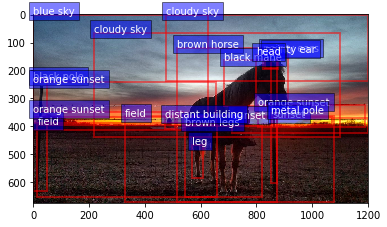

In [15]:

#im_file = 'data/demo/000542.jpg'

###########################
# Similar to get_detections_from_im
conf_thresh=0.4
min_boxes=10
max_boxes=20

im = cv2.imread(im_file)
scores, boxes, attr_scores, rel_scores = im_detect(net, im)

# Keep the original boxes, don't worry about the regression bbox outputs
rois = net.blobs['rois'].data.copy()
# unscale back to raw image space
blobs, im_scales = _get_blobs(im, None)

cls_boxes = rois[:, 1:5] / im_scales[0]
cls_prob = net.blobs['cls_prob'].data
attr_prob = net.blobs['attr_prob'].data
pool5 = net.blobs['pool5_flat'].data

# Keep only the best detections
max_conf = np.zeros((rois.shape[0]))
for cls_ind in range(1,cls_prob.shape[1]):
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
    keep = np.array(nms(dets, cfg.TEST.NMS))
    max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

keep_boxes = np.where(max_conf >= conf_thresh)[0]
if len(keep_boxes) < min_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:min_boxes]
elif len(keep_boxes) > max_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:max_boxes]

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
print(im.shape)
plt.imshow(im)

boxes = cls_boxes[keep_boxes]
objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)
attr_thresh = 0.1
attr = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
attr_conf = np.max(attr_prob[keep_boxes][:,1:], axis=1)

for i in range(len(keep_boxes)):
    bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i]+1]
    if attr_conf[i] > attr_thresh:
        cls = attributes[attr[i]+1] + " " + cls
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print 'boxes=%d' % (len(keep_boxes))

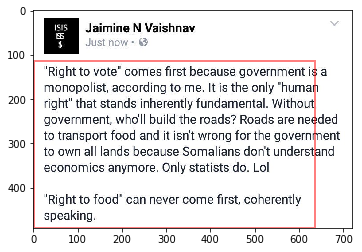

In [57]:
plt.imshow(im)
bbox = boxes[0]
plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )

In [68]:
print(classes)

['__background__', 'yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign', 'cone', 'microwave', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator', 'ostrich', 'bathtub', 'blinds', 'court', 'urinal', 'knee pads', 'bed', 'flamingo', 'giraffe', 'helmet', 'giraffes', 'tennis court', 'motorcycle', 'laptop', 'tea pot', 'horse', 'television', 'shorts', 'manhole', 'dishwasher', 'jeans', 'sail', 'monitor', 'man', 'shirt', 'car', 'cat', 'garage door', 'bus', 'radiator', 'tights', 'sailboat', 'racket', 'plate', 'rock wall', 'beach', 'trolley', 'ocean', 'headboard', 'tea kettle', 'wetsuit', 'tennis racket', 'sink', 'train', 'keyboard', 'sky', 'match', 'train station', 'stereo', 'bats', 'tennis player', 'toilet brush', 'lighter', 'pepper shaker', 'gazebo', 'hair dryer', 'elephant', 'toilet seat', 'zebra', 'skateboa

In [34]:
print(attributes)

['__no_attribute__', 'gray', 'multi colored', 'double decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate', 'khaki', 'apple', 'blowing', 'parked', 'sticking out', 'fluorescent', 'glazed', 'cooking', 'brick', 'home', 'palm', 'curly', 'cheese', 'crashing', 'calm', 'christmas', 'gravel', 'chain link', 'clear', 'cloudy', 'curled', 'striped', 'flying', 'pine', 'arched', 'hardwood', 'silver', 'framed', 'one way', 'tall', 'muscular', 'skiing', 'tiled', 'bare', 'surfing', 'stuffed', 'wii', 'taking off', 'sleeping', 'jumping', 'metal', 'fire', 'neon green', 'soap', 'park', 'chalk', 'license', 'powdered', 'up', 'woven', 'baby', 'polar', 'floppy', 'toasted', 'coffee', 'potted', 'wet', 'tennis', 'dry', 'balding', 'carpeted', 'deep blue', 'cardboard', 'pointed', 'sa